# Fit Sun Topic Model Based on Bradley-Terry Scores of Arguments
This script explored topic model fits using the training set of the original argument collection and their inferred Bradley-Terry scores.
We then choose a specific model fit and use it infer topic loadings on the estimation set to estimate the causal effects of the discovered topics.

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import rc
import re
from sun_topicmodel import suntopic
import torch 

data_dir= Path("~/Dropbox (Princeton)/CF-Text/Software_Data/Data/AutoPersuadePaper_Data_Sep2024/").expanduser()


In [2]:
# import original argument data
df = pd.read_csv(data_dir / "Original_Argument_Collection_with_BT_Scores.csv")

# import argument embeddings 
embeddings = torch.load(data_dir / "Original_Argument_Collection_Embeddings.pt")

embeddings_train = embeddings[df.Training_set == 1]
embeddings_test = embeddings[df.Training_set == 0]
print(f"{embeddings_train.shape = }")

embeddings_train.shape = torch.Size([804, 1536])


# Fit Topic Models

In [3]:
# show mean score by Origin_and_Prompt group 
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = }")
print(f"{df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = } \n")

df[df.Origin_and_Prompt == 'Manual Collection - convincing'].BT_Score.mean() = 1.02960112715376
df[df.Origin_and_Prompt == 'Manual Collection - less convincing'].BT_Score.mean() = 0.9556495575640463
df[df.Origin_and_Prompt == 'GPT only'].BT_Score.mean() = 1.1738390962824408 



In [4]:
# Standardize the input variables 
Y = df.BT_Score[df.Training_set == 1]
Y = Y.to_numpy()
X = np.array(embeddings_train)
print(f" X max: {np.max(X):.4f}, min: {np.min(X):.4f}, mean: {np.mean(X):.4f}, sd: {np.std(X):.4f}")
print(f" Y max: {np.max(Y):.4f}, min: {np.min(Y):.4f} mean: {np.mean(Y):.4f}, sd: {np.std(Y):.4f}")

# X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0)+10**(-10))
X_norm = (X - np.mean(X, axis=0))/(np.std(X,axis=0))
Y_norm = (Y - np.mean(Y))/(np.std(Y))
print(f" X_norm max: {np.max(X_norm):.4f}, min: {np.min(X_norm):.4f}, \
mean: {np.mean(X_norm):.4f}, sd: {np.std(X_norm):.4f}")

print(f" Y_norm max: {np.max(Y_norm):.4f}, min: {np.min(Y_norm):.4f},\
 mean: {np.mean(Y_norm):.4f}, sd: {np.std(Y_norm):.4f}")

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm/(X_norm.shape[1]**0.1)
print(f" X_norm_scaled max: {np.max(X_norm_scaled):.4f}, min: {np.min(X_norm_scaled):.4f}, \
mean: {np.mean(X_norm_scaled):.4f}, sd: {np.std(X_norm_scaled):.4f}")

print(f'{X.shape =}, Y.shape = {Y.shape}')

 X max: 0.2387, min: -0.6837, mean: -0.0007, sd: 0.0255
 Y max: 2.2558, min: 0.4706 mean: 1.0315, sd: 0.2625
 X_norm max: 4.8121, min: -5.1121, mean: 0.0000, sd: 1.0000
 Y_norm max: 4.6644, min: -2.1372, mean: -0.0000, sd: 1.0000
 X_norm_scaled max: 2.3104, min: -2.4545, mean: 0.0000, sd: 0.4801
X.shape =(804, 1536), Y.shape = (804,)


In [5]:
# Initialize suntopic object with random alpha and num_bases
model = suntopic(Y_norm, X_norm_scaled, alpha = 0.5, num_bases = 10, random_state = 0)

# Use cross validation to find optimal alpha and numbases values
model.hyperparam_cv(alpha_range = np.linspace(0.1,0.9,9), num_bases_range = range(2,21), cv_folds= 10,
    random_state = 0, niter = 100, parallel=True)

## Calculate Benchmarks

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

def run_fold(train, test, X, Y, base_random_state):
    """
    Function to train and evaluate models on a single fold, ensuring consistent randomness.

    Parameters:
        train (array-like): Indices for training data.
        test (array-like): Indices for testing data.
        X (array-like): Feature matrix.
        Y (array-like): Response vector.
        fold_index (int): Index of the current fold to set a unique random state.
        base_random_state (int): Base seed for reproducibility.

    Returns:
        dict: MSE scores for Lasso, Gradient Boosting Regressor, and Random Forest Regressor.
    """
    # Create a unique random state for each fold based on the base seed
    fold_random_state = base_random_state
    results = {}

    # Lasso Regression
    lasso_reg = Lasso(alpha=1, random_state=fold_random_state).fit(X[train], Y[train])
    lasso_pred = lasso_reg.predict(X[test])
    results['Lasso'] = mean_squared_error(Y[test], lasso_pred)

    # Gradient Boosting Regressor
    gbr_reg = GradientBoostingRegressor(random_state=fold_random_state).fit(X[train], Y[train])
    gbr_pred = gbr_reg.predict(X[test])
    results['GradientBoostReg'] = mean_squared_error(Y[test], gbr_pred)

    # Random Forest Regressor
    rf_reg = RandomForestRegressor(random_state=fold_random_state).fit(X[train], Y[train])
    rf_pred = rf_reg.predict(X[test])
    results['RandomForestReg'] = mean_squared_error(Y[test], rf_pred)

    return results

def parallel_crossval(X, Y, cv_folds=10, random_state=0, export_dir=None, export_name=None, n_jobs=-1):
    """
    Parallelized function to perform cross-validation benchmarks with consistent random state control.

    Parameters:
        cv_folds (int): Number of cross-validation folds.
        X (array-like): Feature matrix.
        Y (array-like): Response vector.
        random_state (int): Seed for reproducibility.
        export_dir (str): Directory to save results.
        export_name (str): Filename to save results.
        n_jobs (int): Number of parallel jobs (default -1 uses all available cores).

    Returns:
        mse_scores (DataFrame): DataFrame with MSE scores for each model and fold.
    """

    # Initialize KFold object
    kf = KFold(n_splits=cv_folds, random_state=random_state, shuffle=True)
    kfolds = list(kf.split(X))

    # Parallel execution across folds with consistent random state control
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_fold)(train, test, X, Y, random_state) for train, test in kfolds
    )

    # Create DataFrame from results
    mse_scores = pd.DataFrame(results)

    # Export results to CSV if specified
    if export_dir and export_name:
        mse_scores.to_csv(export_dir + export_name, index=False)

    return mse_scores

# Example usage
cv_folds = 10
random_state = 0
mse_results = parallel_crossval(
    cv_folds=cv_folds,
    X=X_norm_scaled,
    Y=Y_norm,
    random_state=random_state,
    n_jobs= 10 # Assumes there are 10 cores available
)


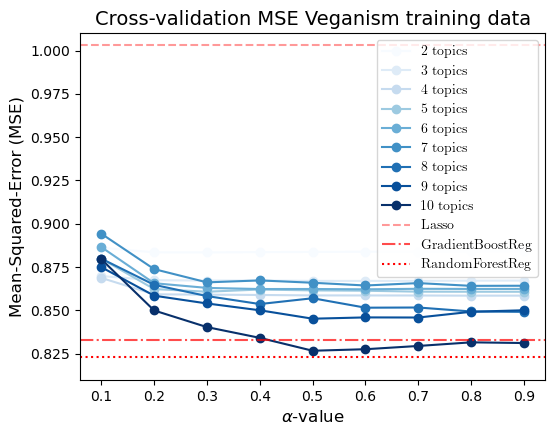

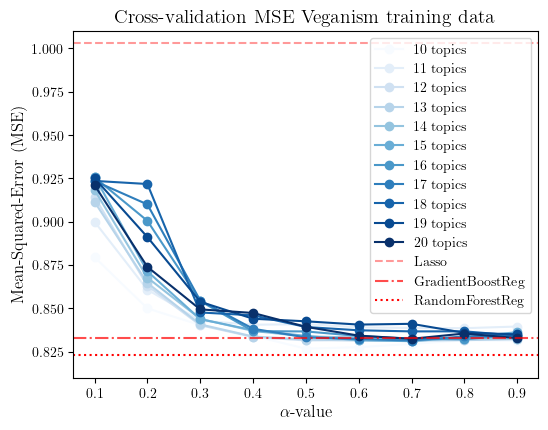

In [7]:
# Recreate Figure 2 (and 4) of the Autopersuade paper
topic_ranges = [range(2, 11), range(10, 21)]
figure_names = ["Veganism_Cross_Validation.png", "Veganism_Cross_Validation_more_Topics.png"]

alpha_range = np.linspace(0.1, 0.9, 9)
mse_scores_bm = mse_results.mean(axis=0)
mse_scores = np.mean(model.cv_errors, axis=2)
mse_scores_list = [mse_scores[:9,:], mse_scores[8:,:]]

for j in range(2):

    topic_range = topic_ranges[j]
    mse_scores = mse_scores_list[j]

    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))  # Adjust figure size as needed
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rcParams['text.usetex'] = True

    colors = plt.cm.Blues(np.linspace(0, 1, len(topic_range)))
    for i, num_bases in enumerate(topic_range):
        ax.plot(
            alpha_range,
            mse_scores[i],
            label=f"{num_bases} topics",
            marker="o",
            color = colors[i],
                )

    # Add straight lines at the benchmark values in mse_scores_bm in red 
    line_styles = [ '--', '-.', ':']
    for i in range(0, len(mse_scores_bm)):
        ax.axhline(mse_scores_bm[i], color="red", linestyle=line_styles[i], alpha=0.4 + 0.3 * i, label=mse_scores_bm.index[i])

    # Plot the MSE scores for each number of topics
    ax.set_title(f"Cross-validation MSE Veganism training data", fontsize=14)
    ax.set_xlabel(r"$\alpha$-value", fontsize=12)
    ax.set_ylim(0.81,1.01)
    ax.set_ylabel("Mean-Squared-Error (MSE)", fontsize=12)

    # Set less transparent legend
    ax.legend(framealpha=.50)
    ax.legend(loc= 'upper right')
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

    # export the plot
    fig.savefig(data_dir / figure_names[j], bbox_inches="tight", dpi=600)


# Explore specific model fits   

In [8]:
def model_fitting(
        embeddings,
        Y, 
        num_bases = 10,
        random_state = 0,
        alpha = 0.2,
        niter = 100,
        test_size = 0.2,
        n_sent = 10,
        df = df,
        save_model = False,
        sample_documents = False,
): 
        """
        Fits a topic model using the provided embeddings and response variables, evaluates the model's performance, and generates 
        sample text data with topic information.

        Parameters:
        - embeddings: array-like
                The embeddings to be used as input features for model fitting.
        - Y: array-like
                The response variable for model fitting.
        - num_bases: int, optional (default=10)
                Number of bases (topics) to be used in the model.
        - random_state: int, optional (default=0)
                Random seed for reproducibility.
        - alpha: float, optional (default=0.2)
                Regularization parameter for the model.
        - niter: int, optional (default=100)
                Number of iterations for model fitting.
        - test_size: float, optional (default=0.2)
                Proportion of data to be used for testing.
        - n_sent: int, optional (default=10)
                Number of samples to display per topic in the output text file.
        - df: pandas DataFrame, optional (default=None)
                DataFrame containing the text data and associated metadata.
        - save_model: bool, optional (default=False)
                Whether to save the fitted model to disk.
        - sample_documents: bool, optional (default=False)
                Whether to generate a text file with sample documents.
        - return_test_mse: bool, optional (default=False)
                Whether to return the test MSE.
        - return_train: bool, optional (default=False)
                Whether to return the indices of the training data.

        Returns:
        - train: array-like,
                Indices of the training set if `return_train` is True.
        - in_sample_mse: float
                Mean squared error of the in-sample predictions.
        - test_mse: float
                Mean squared error of the out-of-sample predictions.
        - model: suntopic object
                Fitted model object.
        - sample_documents_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{test_size}testsize.txt: txt file, optional
                Text file containing sample data with topic information.
        - suntopic_model_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{test_size}testsize.npz: npz file, optional
                File containing the fitted model if `save_model` is True.
        """

        # Normalize embeddings and response variable
        X = np.array(embeddings)
        X_norm = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
        Y_norm = (Y - np.mean(Y)) / np.std(Y)
        X_norm_scaled = X_norm / (X_norm.shape[1] ** 0.1)

        # Split data into training and test sets
        np.random.seed(random_state)
        test = np.sort(np.random.choice(len(Y), int(len(Y) * test_size), replace=False))
        train = np.setdiff1d(np.arange(len(Y)), test)

        # Fit the topic model
        model = suntopic(Y_norm[train], X_norm_scaled[train], alpha=alpha, num_bases=num_bases, random_state=random_state)
        model.fit(niter=niter)
        W_snmf = model.get_topics()
        H_snmf = model.get_coefficients()

        # Evaluate model performance
        in_sample_mse = np.mean((Y_norm[train] - np.dot(W_snmf, H_snmf[:, -1]) * ((1 - alpha) ** -0.5)) ** 2)
        Y_pred = model.predict(X_new=X_norm_scaled[test], random_state=random_state, niter=niter)
        test_mse = np.mean((Y_pred - Y_norm[test]) ** 2)

        if sample_documents == True:
                # Prepare DataFrame for sample generation
                df = df.reset_index(drop=True).iloc[train].reset_index(drop=True)

                pd.set_option('display.max_colwidth', 1)
                text =  ""
                with open(f'sample_documents_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{test_size}testsize.txt', 'w') as f:
                        for i in range(0, num_bases):
                                highest_ci = np.argsort(W_snmf[:,i])[-n_sent:]
                                text += f"Samples with highest value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"


                                for idx in highest_ci[::-1]:
                                        sample_text = df['New_Argument'][idx].strip().replace('\n', ' ')
                                        sample_label = np.round(Y_norm[idx],decimals= 2)
                                        text += f" Label: {sample_label}, {df.Origin_and_Prompt[idx][-15:]} || "
                                        text += f"Original: {df.Original_ID[idx]:03d}, Categorie: {str(df.Categories[idx]):20s}, {str(df.Subcategories[idx]):27s}||"
                                        text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                        text += f" {sample_text}\n"
                                text += "\n"

                                medium_ci = np.argsort(W_snmf[:,i])[int(len(W_snmf[:,i])/2)-int(n_sent/2):int(len(W_snmf[:,i])/2)+int(n_sent/2)]
                                text += f"Samples with medium value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"

                                for idx in medium_ci[::-1]:
                                        sample_text = df['New_Argument'][idx].strip().replace('\n', ' ')
                                        # sample_label = np.round(df['thumbs_up_rate'][idx], decimals=2)
                                        sample_label = np.round(Y_norm[idx],decimals= 2)
                                        text += f" Label: {sample_label} || "
                                        text += f"Original: {df.Original_ID[idx]:03d}, Categorie: {str(df.Categories[idx]):20s}, {str(df.Subcategories[idx]):27s}||"
                                        text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                        text += f" {sample_text}\n"
                                text += "\n"

                                lowest_ci = np.argsort(W_snmf[:,i])[:n_sent]
                                text += f"Samples with lowest value in column {i} of W_snmf with associated beta {np.round(H_snmf[i,-1], decimals=2)}:\n"

                                for idx in lowest_ci[::-1]:
                                        sample_text = df['New_Argument'][idx].strip().replace('\n', ' ')
                                        # sample_label = np.round(df['forwards_rate'][idx],decimals= 4)
                                        sample_label = np.round(Y_norm[idx],decimals= 2)
                                        text += f" Label: {sample_label} || "
                                        text += f"Original: {df.Original_ID[idx]:03d}, Categorie: {str(df.Categories[idx]):20s}, {str(df.Subcategories[idx]):27s}||"
                                        text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                        text += f" {sample_text}\n"
                                text +=  "_____"*100 + "\n\n" 


                        text += "_____"*100 + "\n" + "_____"*100 + "\n" + "_____"*100 + "\n"
                        highest_ci = np.argsort(W_snmf[:,0] + W_snmf[:,1])[-n_sent:]
                        text += f"Samples with highest sum of in column 0 and column 1 of W_snmf:\n"
                        for idx in highest_ci[::-1]:
                                sample_text = df['New_Argument'][idx].strip().replace('\n', ' ')
                                sample_label = np.round(Y_norm[idx],decimals= 2)
                                text += f" Label: {sample_label} || "
                                text += f"Original: {df.Original_ID[idx]:03d}, Categorie: {str(df.Categories[idx]):20s}, {str(df.Subcategories[idx]):27s}||"
                                text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"

                                text += f" {sample_text}\n"
                        text +=  "\n\n" 

                        highest_ci = np.argsort(W_snmf[:,-2] + W_snmf[:,-1])[-n_sent:]
                        text += f"Samples with highest sum of in column 8 and column 9 of W_snmf:\n"
                        for idx in highest_ci[::-1]:
                                sample_text = df['New_Argument'][idx].strip().replace('\n', ' ')
                                sample_label = np.round(Y_norm[idx],decimals= 2)
                                text += f" Label: {sample_label} || "
                                text += f"Original: {df.Original_ID[idx]:03d}, Categorie: {str(df.Categories[idx]):20s}, {str(df.Subcategories[idx]):27s}||"
                                text +=  "Topics: " + " ".join([f"{x:.2f}" for x in W_snmf[idx, :]]) + " ||"
                                text += f" {sample_text}\n"


                        text = re.sub(' +', ' ', text)
                        f.write(text)
                
        if save_model == True: 
                model.save(f"suntopic_model_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{test_size}testsize")
                print(f"Model saved in suntopic_model_topics{num_bases}_{random_state}RandomState_{alpha}Alpha_{test_size}testsize.npz")
        

        return train, in_sample_mse, test_mse, model

In [9]:
# Fit and savea model with optimal hyperparameters
# Export documents for topic labelling and train_idx to understand which subset of the training data was used
train_idx, in_sample_mse, test_mse, model = model_fitting(
        embeddings = embeddings_train,
        Y = np.array(df.BT_Score[df.Training_set == 1]),
        num_bases = 10,
        random_state = 44,
        alpha = 0.5,
        niter = 100,
        test_size = 0.2,
        n_sent = 20,
        df = df[df.Training_set == 1],
        save_model = True,
        sample_documents = True,)

print(f"In sample MSE: {in_sample_mse:.02}\nTest sample MSE: {test_mse:.02}")

Model saved in suntopic_model_topics10_44RandomState_0.5Alpha_0.2testsize.npz
In sample MSE: 0.82
Test sample MSE: 0.7


### Evaluating Topic Coherence
Calculate a topic coherence measure based on [Optimizing Semantic Coherence in Topic Models](https://aclanthology.org/D11-1024) (Mimno et al., EMNLP 2011).

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def calculate_tfidf_scores(df, n_top_words=15, n_top_docs=50):
    """
    Calculate the top TF-IDF words for each topic from a CSV file.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the topic loadings and text documents.
        n_top_words (int): The number of top words to select per topic.
        n_top_docs (int): The number of top documents to consider for each topic.

    Returns:
        pd.DataFrame: A DataFrame containing the top words for each topic.
    """
    
    # Get all columns that include "inf" (or adjust based on your need)
    topic_columns = [col for col in df.columns if "inf" in col]

    # Extract all 'New_Argument' entries to use for IDF calculation
    all_documents = df['New_Argument'].fillna('')

    # Initialize the TF-IDF Vectorizer using the entire corpus for the IDF calculation
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

    # Fit the vectorizer on the entire corpus to establish the IDF scores
    vectorizer.fit(all_documents)

    # Initialize a dictionary to store TF-IDF scores for each topic
    tfidf_scores = {}

    # Iterate over each topic column
    for topic in topic_columns:
        # Select the top documents based on the loading in the topic column
        top_docs = df.nlargest(n_top_docs, topic)

        # Extract the 'New_Argument' column corresponding to these top documents
        top_texts = top_docs['New_Argument'].fillna('')

        # Transform the top texts using the pre-fitted vectorizer
        tfidf_matrix = vectorizer.transform(top_texts)

        # Get feature names (words)
        feature_names = vectorizer.get_feature_names_out()

        # Sum the TF-IDF scores for each word across all documents to find the most important words
        summed_tfidf = tfidf_matrix.sum(axis=0).A1

        # Create a dictionary of words and their summed TF-IDF scores
        tfidf_dict = dict(zip(feature_names, summed_tfidf))

        # Sort the words by their TF-IDF scores in descending order
        sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)

        # Store the top words for this topic in the dictionary
        tfidf_scores[topic] = [word for word, score in sorted_tfidf[:n_top_words]]

    # Convert the dictionary to a DataFrame
    df_tfidf = pd.DataFrame.from_dict(tfidf_scores, orient='index').transpose()

    return df_tfidf

def calculate_topic_coherence(df_tfidf, documents):
    """
    Calculate topic coherence scores based on TF-IDF results.

    Parameters:
        df_tfidf (pd.DataFrame): DataFrame containing the top words for each topic.
        documents (pd.Series): Series of text documents to be analyzed.

    Returns:
        dict: A dictionary of coherence scores for each topic.
    """
    # Convert documents to lowercase
    documents = documents.str.lower()

    # Helper functions to calculate document and co-document frequencies
    def document_frequency(word, documents):
        return sum(1 for doc in documents if word in doc)

    def co_document_frequency(word1, word2, documents):
        return sum(1 for doc in documents if word1 in doc and word2 in doc)

    # Construct the topics_words dictionary
    topics_words = {topic: df_tfidf[topic].dropna().tolist() for topic in df_tfidf.columns}

    # Calculate topic coherence for each topic
    topic_coherence_scores = {}

    for topic, words in topics_words.items():
        M = len(words)
        coherence = 0.0
        
        # Iterate over word pairs (v_m, v_l) with m > l
        for m in range(1, M):
            for l in range(m):
                word_m = words[m]
                word_l = words[l]

                # Calculate document frequencies
                D_vl = document_frequency(word_l, documents)
                D_vm_vl = co_document_frequency(word_m, word_l, documents)
                
                # Apply the coherence formula if D_vl is non-zero
                if D_vl != 0:
                    coherence += np.log((D_vm_vl + 1) / (D_vl))

        # Store the coherence score for the topic
        topic_coherence_scores[topic] = coherence

    return topic_coherence_scores

def model_fitting_eval(
                model,
                df = df,
                embeddings = embeddings,
                print_tfidf = False,
                n_top_words = 10,
                n_top_docs = 100,
                random_state = 44,
): 
        
        ## standardize test data using the training data mean and standard deviation
        Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
        X_train = np.array(embeddings)

        Y = np.array(df.BT_Score) ## match previous edit to shift the distribution
        X = np.array(embeddings)
        X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))

        #  standardize the factorized matrix 
        W_snmf = model.get_topics()
        H_snmf = model.get_coefficients()
        S = np.diag(np.std(W_snmf, axis=0))
        W_norm = W_snmf @ np.linalg.inv(S)
        H_norm = S @ H_snmf

        # Set model parameters as these standardized values
        model.model.W = W_norm
        model.model.H = H_norm

        # Scale down the high-dimensional embedding to avoid dominance 
        X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)

        # Infer topic loadings and predict response variable for the entire dataset
        Y_pred, W_pred = model.predict(X_new=X_norm_scaled, random_state=random_state, niter=100, return_topics=True)

        # create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
        for i in range(10):
                df[f"topic_{i+1}_inf"] = W_pred[:,i]
                
        # Step 1: Calculate TF-IDF scores
        df_tfidf = calculate_tfidf_scores(df, n_top_words = n_top_words, n_top_docs = n_top_docs)
        if print_tfidf:
                print(df_tfidf.to_markdown(index=False))

        # Step 2: Calculate topic coherence scores
        documents = df['New_Argument'].fillna('')
        topic_coherence_scores = calculate_topic_coherence(df_tfidf, documents)

        # Display the topic coherence scores and calculate the mean
        total_score = 0
        for topic, score in topic_coherence_scores.items():
                total_score += score

        # Calculate the mean coherence score
        mean_coherence = total_score / len(topic_coherence_scores)

        return mean_coherence



In [11]:
# Create indicator for subset of training data that was used to fit the model
model_fit_idx = np.zeros(sum(df.Training_set == 1))
model_fit_idx[train_idx] = 1
df["model_fit_idx"] = 0
df.loc[df.Training_set == 1, "model_fit_idx"] = model_fit_idx

embeddings_model_fit = embeddings_train[train_idx,:]

In [12]:
## standardize test data using the training data mean and standard deviation
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

Y = np.array(df.BT_Score) ## match previous edit to shift the distribution
X = np.array(embeddings)
X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
Y_norm = (Y - np.mean(Y_train))/(np.std(Y_train))

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)

# Load saved topic model
model = suntopic(Y_norm[train_idx], X_norm_scaled[train_idx], alpha = 0.5, num_bases = 10, random_state = 44)
model = model.load("suntopic_model_topics10_44RandomState_0.5Alpha_0.2testsize.npz")

#  standardize the factorized matrix 
W_snmf = model.get_topics()
H_snmf = model.get_coefficients()
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)
H_norm = S @ H_snmf

# Set model parameters as these standardized values
model.model.W = W_norm
model.model.H = H_norm

# Infer topic loadings and predict response variable for the entire dataset
Y_pred, W_pred = model.predict(X_new=X_norm_scaled, random_state=44, niter=100, return_topics=True)

# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(10):
        df[f"topic_{i+1}_inf"] = W_pred[:,i]

# df.to_csv(data_dir / "Generated_Veganism_Arguments_with_BT_Score_and_Topics.csv", index=False)

In [13]:
print('Top 10 words per topic for selected model fit:')
mean_coherence = model_fitting_eval(
    model = model,
    df = df,
    embeddings = embeddings, 
    print_tfidf = True,
)

print(f"\n Mean coherence score: {mean_coherence:.2f}")

Top 10 words per topic for selected model fit:
| topic_1_inf     | topic_2_inf   | topic_3_inf   | topic_4_inf   | topic_5_inf   | topic_6_inf   | topic_7_inf   | topic_8_inf   | topic_9_inf   | topic_10_inf   |
|:----------------|:--------------|:--------------|:--------------|:--------------|:--------------|:--------------|:--------------|:--------------|:---------------|
| farms           | water         | animals       | meat          | dairy         | change        | human         | health        | dairy         | climate        |
| factory         | global        | veganism      | consumption   | cows          | veganism      | animals       | vegan         | water         | emissions      |
| animal          | food          | life          | ethical       | hens          | carbon        | humans        | diet          | cows          | change         |
| meat            | 70            | compassion    | animals       | years         | meat          | exploitation  | diets       

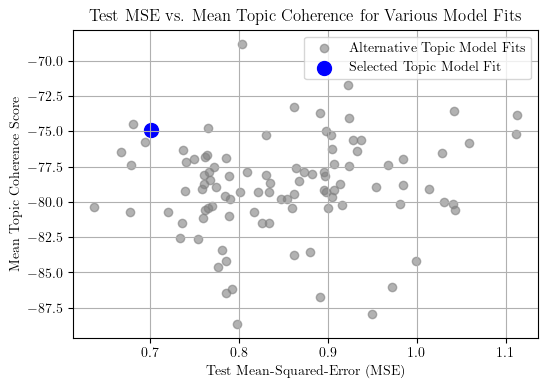

In [14]:

# Set parameters
num_bases = 10
alpha = 0.5
niter = 100
test_size = 0.2
n_sent = 20
model_name = "coherence_test"

# Draw 100 random random states
np.random.seed(0)
random_states = np.random.choice(range(1000), 99, replace=False)
random_states = [44] + list(random_states)
results = []

# Loop over random states
for random_state in random_states:
    # Fit the model and calculate test MSE
    train, in_sample_mse, test_mse, model = model_fitting(
        embeddings=embeddings_train,
        Y=np.array(df.BT_Score[df.Training_set == 1]),
        num_bases=num_bases,
        random_state=random_state,
        alpha=alpha,
        niter=niter,
        test_size=test_size,
    )

    # Calculate topic coherence scores
    topic_coherence_scores = model_fitting_eval(
        model= model,
        df=df,
        embeddings=embeddings,
        random_state=random_state,
    )

    mean_coherence_score = topic_coherence_scores
    results.append((random_state, test_mse, mean_coherence_score))

# Convert results to DataFrame for easier plotting and analysis
results_df = pd.DataFrame(results, columns=['random_state', 'test_mse', 'mean_coherence_score'])

# Specific highlight for random_state = 44
highlight_state = 44
highlight_row = results_df[results_df['random_state'] == highlight_state]

# Plotting the results
plt.figure(figsize=(6, 4))
plt.scatter(results_df['test_mse'], results_df['mean_coherence_score'], c='grey', alpha=0.6, label='Alternative Topic Model Fits')
plt.scatter(highlight_row['test_mse'], highlight_row['mean_coherence_score'], c='blue', s=100, label=f'Selected Topic Model Fit')

plt.xlabel('Test Mean-Squared-Error (MSE)')
plt.ylabel('Mean Topic Coherence Score')
plt.title('Test MSE vs. Mean Topic Coherence for Various Model Fits')
plt.grid(True)
plt.legend()

plt.savefig(data_dir / "Veganism_Test_MSE_vs_Mean_Topic_Coherence_Score.png", bbox_inches='tight')

plt.show()


In [15]:
# Create indicator for subset of training data that was used to fit the model
model_fit_idx = np.zeros(sum(df.Training_set == 1))
model_fit_idx[train_idx] = 1
df["model_fit_idx"] = 0
df.loc[df.Training_set == 1, "model_fit_idx"] = model_fit_idx

embeddings_model_fit = embeddings_train[train_idx,:]

In [16]:
## standardize test data using the training data mean and standard deviation
Y_train = np.array(df.BT_Score[df.model_fit_idx == 1])
X_train = np.array(embeddings_model_fit)

Y = np.array(df.BT_Score) ## match previous edit to shift the distribution
X = np.array(embeddings)
X_norm = (X - np.mean(X_train, axis=0))/(np.std(X_train,axis=0))
Y_norm = (Y - np.mean(Y_train))/(np.std(Y_train))

# Scale down the high-dimensional embedding to avoid dominance 
X_norm_scaled = X_norm /(X_norm.shape[1]**0.1)

# Load saved topic model
model = suntopic(Y_norm[train_idx], X_norm_scaled[train_idx], alpha = 0.5, num_bases = 10, random_state = 44)
model = model.load("suntopic_model_topics10_44RandomState_0.5Alpha_0.2testsize.npz")

#  standardize the factorized matrix 
W_snmf = model.get_topics()
H_snmf = model.get_coefficients()
S = np.diag(np.std(W_snmf, axis=0))
W_norm = W_snmf @ np.linalg.inv(S)
H_norm = S @ H_snmf

# Set model parameters as these standardized values
model.model.W = W_norm
model.model.H = H_norm

# Infer topic loadings and predict response variable for the entire dataset
Y_pred, W_pred = model.predict(X_new=X_norm_scaled, random_state=44, niter=100, return_topics=True)

# create 10 new columns in df called topic_1_og, topic_2_og, ... topic_10_og
for i in range(10):
        df[f"topic_{i+1}_inf"] = W_pred[:,i]

# df.to_csv(data_dir / "Generated_Veganism_Arguments_with_BT_Score_and_Topics.csv", index=False)

In [17]:
print('Top 10 words per topic for selected model fit:')
mean_coherence = model_fitting_eval(
    model = model,
    df = df,
    embeddings = embeddings, 
    random_state=44,
)

print(f"\n Mean coherence score: {mean_coherence:.2f}")

Top 10 words per topic for selected model fit:

 Mean coherence score: -74.92


# Causal Inference
Using the data documents in the test set and their inferred topic loadings, we now estimate the causal effects of the latent topics

In [18]:
import statsmodels.api as sm

# Extract causal estimation data
W_pred_causal = W_pred[df.Training_set == 0, :]
Y_test_causal = Y_norm[df.Training_set == 0]

# run OLS regression of pred_latent on Y_norm
X = sm.add_constant(W_pred_causal)  # Add a constant term to the predictor variable
model = sm.OLS(Y_test_causal, X)
results = model.fit()

# Generate LaTeX output table without confidence intervals
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.167
No. Observations:                 505   F-statistic:                     11.09
Covariance Type:            nonrobust   Prob (F-statistic):           3.73e-17
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0512      0.124     -0.412      0.681      -0.295       0.193
x1            -0.0131      0.029     -0.446      0.655      -0.071       0.045
x2             0.1428      0.029      4.861      0.000       0.085       0.201
x3             0.0086      0.033      0.260      0.795      -0.056       0.074
x4            -0.1235      0.029     -4.234      0.000      -0.181      -0.066
x5            -0.0272      0.027     -0.997      0.319      -0.081       0.026
x6             0.0627      0.029      2.145      0.032       0.005       0.120
x7            -0.1699      0.030     -5.604      0.000      -0.230      -0.110
x8             0.1071      0.030      3.572      0.000       0.048       0.166
x9            -0.0859      0.030     -2.873      0.004      -0.145      -0.027
x10            0.0592      0.031      1.929      0.054      -0.001       0.119
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

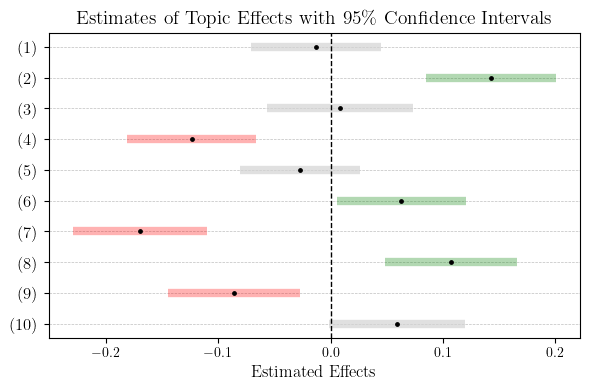

In [19]:
# Set font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True

# Extract parameters and confidence intervals from the regression results
params = results.params[1:]
conf_int = results.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0<= upper:
        ax.plot([lower, upper], [i, i], color='lightgray', linewidth=6, solid_capstyle='butt', alpha=0.7)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot([lower, upper], [i, i], color='red', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)
    
    else: 
        ax.plot([lower, upper], [i, i], color='green', linewidth=6, solid_capstyle='butt', alpha=0.3)
        ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

# Customize the plot
ax.axvline(0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels( [f"({i+1})" for i in range(len(results.params)-1)], fontsize=12)
ax.set_xlabel('Estimated Effects', fontsize=12)
# include lin break in the title
ax.set_title('Estimates of Topic Effects with 95\% Confidence Intervals', fontsize=14)


# Save or show the plot
plt.tight_layout()
plt.savefig( str(data_dir) + '/Veganism_Causal_Effects.png',bbox_inches="tight", dpi=600)  # Save the plot as an image file
plt.show()


### Explore the inclusion of argument length

In [20]:
arg_len = df.New_Argument.str.len()
df_W_pred_causal = pd.DataFrame(W_pred_causal)
df_W_pred_causal.columns = [f"topic_{i+1}_inf" for i in range(10)]
df_W_pred_causal["Arg_len"] = arg_len[df.Training_set == 0].reset_index(drop=True)

# run OLS regression of pred_latent on Y_norm
X = sm.add_constant(df_W_pred_causal)  # Add a constant term to the predictor variable
model = sm.OLS(Y_test_causal, X)
results = model.fit()

# Generate output table without confidence intervals
results.summary(slim=True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.242
No. Observations:                 505   F-statistic:                     15.66
Covariance Type:            nonrobust   Prob (F-statistic):           2.37e-26
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.4469      0.230     -6.299      0.000      -1.898      -0.996
topic_1_inf     -0.0164      0.028     -0.586      0.558      -0.071       0.039
topic_2_inf      0.1334      0.028      4.757      0.000       0.078       0.188
topic_3_inf      0.0237      0.032      0.748      0.455      -0.039       0.086
topic_4_inf     -0.1351      0.028     -4.847      0.000      -0.190      -0.080
topic_5_inf     -0.0194      0.026     -0.745      0.456      -0.071       0.032
topic_6_inf      0.0577      0.028      2.070      0.039       0.003       0.112
topic_7_inf     -0.1779      0.029     -6.147      0.000      -0.235      -0.121
topic_8_inf      0.1046      0.029      3.659      0.000       0.048       0.161
topic_9_inf     -0.0930      0.029     -3.261      0.001      -0.149      -0.037
topic_10_inf     0.0403      0.029      1.372      0.171      -0.017       0.098
Arg_len          0.0052      0.001      7.091      0.000       0.004       0.007
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

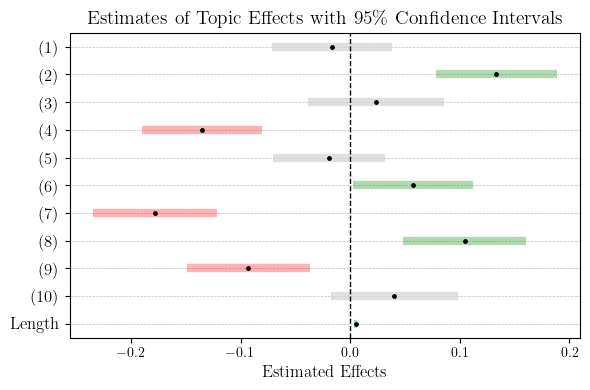

In [21]:

# Extract parameters and confidence intervals from the regression results
params = results.params[1:]  # Exclude the constant
conf_int = results.conf_int()[1:]  # Exclude the constant's confidence interval

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

# Iterate over the parameters and confidence intervals
for i, (param, (lower, upper)) in enumerate(zip(params, conf_int.values)):
    # Add horizontal lines between rows
    ax.axhline(i, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Determine color based on whether the confidence interval includes zero
    if lower <= 0 <= upper:
        color = 'lightgray'  # Gray if zero is included in the interval
        alpha = 0.7
    elif lower > 0:
        color = 'green'  # Green if the interval is entirely above zero
        alpha = 0.3
    else:
        color = 'red'  # Red if the interval is entirely below zero
        alpha = 0.3

    # Plot the confidence interval as a line
    ax.plot([lower, upper], [i, i], color=color, linewidth=6, solid_capstyle='butt', alpha=alpha)
    # Plot the parameter estimate as a scatter point
    ax.scatter(param, i, marker='o', s=6, color='black', zorder=10)

# Customize the plot
ax.axvline(0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph to match traditional regression output
ax.set_yticks(np.arange(len(params)))
# Create y-axis labels for the parameters
ax.set_yticklabels([f"({i+1})" for i in range(len(params) -1)] + ["Length"], fontsize=12)
ax.set_xlabel('Estimated Effects', fontsize=12)
ax.set_title('Estimates of Topic Effects with 95\\% Confidence Intervals', fontsize=14)

# Save or show the plot
plt.tight_layout()
plt.show()
